# Data Preprocessing and SVD Analysis
This notebook performs text preprocessing, TF-IDF vectorization, and dimensionality reduction using SVD/PCA on earnings call transcripts. The goal is to analyze sector-based clustering of companies.

# 1. Imports

In [2]:
# Standard Library
import os
import glob
import re
from pathlib import Path

# Data Manipulation & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Text Processing
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE

# NLP Tools
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Matrix Completion
from fancyimpute import SoftImpute


# 2. Data Settings

---

### 2.1. Custom Stopword Compilation
This notebook defines a comprehensive set of custom stopwords to improve the quality of text analysis on earnings call transcripts. The table below summarizes each category:

| **Category**                  | **Description**                                                                 |
|------------------------------|---------------------------------------------------------------------------------|
| Company-specific         | Names and aliases of companies (e.g., "meta", "jp morgan", "nvidia")           |
| Domain-specific          | Roles and filler words common in financial speech (e.g., "ceo", "analyst")     |
| Name stopwords           | First/last names of speakers to reduce individual bias                         |
| Month/time stopwords     | Temporal terms like months and quarters ("jan", "Q1")                          |
| Transcript stopwords     | Common transcript metadata (e.g., "goldman", "quarterly", "transcript")        |
| Mid-sentence fillers     | Verbal tics and soft phrases (e.g., "uh", "yeah", "actually")                  |
| Negation/bad words       | Partial negations and contractions that add noise (e.g., "don", "isn")         |
| Platform-specific        | Product and platform terms (e.g., "azure", "youtube", "facebook")             |
| Additional English       | Reserved for any manually added stopwords beyond scikit-learn defaults         |

All sets are unified into a single `custom_stopwords` list using Python `set.union()` for streamlined filtering during preprocessing.

In [3]:
# -----------------------------
# Company-specific Stopwords
# -----------------------------
company_stopwords = {
        # 3M
    "3m",
    "3m co",
    "3m company",
    "mmm",

    # AMD
    "advanced micro devices",
    "amd",
    "amd corporation",
    "amd inc",

    # American Airlines
    "aa",
    "aal",
    "aal inc",
    "american airlines",
    "american airlines inc",
    "americanairlines",

    # ASML
    "asml",
    "asml holding",
    "asml holding nv",
    "asml holding n.v.",
    "asml holdings",
    "asml holdings nv",

    # Blackstone
    "blackstone",
    "blackstone group",
    "blackstone inc",
    "blackstone lp",
    "bx",

    # CBRE
    "cbre",
    "cbre group",
    "cbre group inc",
    "cbre inc",

    # Citigroup
    "c",
    "citi",
    "citi bank",
    "citi group inc",
    "citigroup",
    "citigroup inc",

    # Cushman & Wakefield
    "cwk",
    "cushman",
    "cushman & wakefield",
    "cushman & wakefield plc",
    "cushman and wakefield",
    "cushmanwakefield",
    "wakefield",

    # Delta Airlines
    "dal",
    "dal inc",
    "delta",
    "delta air lines",
    "delta air lines inc",
    "delta air lines, inc.",
    "delta airlines",

    # Equinix
    "equinix",
    "equinix inc",
    "equinix, inc.",
    "eqix",

    # Intel
    "intel",
    "intel corp",
    "intel corp inc",
    "intel corporation",
    "intel corporation inc",
    "intc",

    # JPMorgan Chase
    "chase",
    "jpm",
    "jpmc",
    "jp morgan",
    "jpmorgan",
    "jpmorgan chase",
    "jpmorgan chase & co",
    "jpmorgan chase & co inc",
    "jpmorgan chase & co.",
    "jpmorgan chase & company",
    "jpmorgan chase co",
    "jpmorgan chase co inc",
    "jpmorgan chase co inc.",
    "jpmorgan chase co.",

    # Meta (Facebook)
    "fb",
    "facebook",
    "facebook inc",
    "meta",
    "meta platforms",
    "meta platforms inc",
    "meta platforms, inc.",

    # Microsoft
    "microsoft",
    "microsoft co",
    "microsoft co.",
    "microsoft corp",
    "microsoft corp inc",
    "microsoft corporation",
    "msft",

    # Netflix
    "netflix",
    "netflix inc",
    "netflix, inc.",
    "nflx",

    # Nvidia
    "cuda",
    "geforce",
    "gtx",
    "nvda",
    "nvidia",
    "nvidia corporation",
    "nvidia corporation inc",
    "nvidia corp",
    "nvidia corp inc",
    "nvidia, inc.",
    "rtx",

    # Procter & Gamble
    "p&g",
    "pg",
    "procter",
    "procter & gamble",
    "procter & gamble co",
    "procter & gamble co.",
    "procter & gamble company",
    "procter and gamble",
    "procter and gamble co",

    # Southwest Airlines
    "luv",
    "southwest",
    "southwest air",
    "southwest airlines",
    "southwest airlines co",
    "southwest airlines company",

    # TSMC
    "tsm",
    "tsmc",
    "tsmc co.",
    "tsmc ltd",
    "taiwan semiconductor",
    "taiwan semiconductor manufacturing",
    "taiwan semiconductor manufacturing company limited",

    # Uber
    "uber",
    "uber inc",
    "uber technologies",
    "uber technologies inc",
    "uber technologies, inc",
    "uber technologies, inc.",

    # United Airlines
    "ual",
    "ual inc",
    "united",
    "united air",
    "united air lines",
    "united air lines inc",
    "unitedairlines",
    "united airlines",
    "united airlines holdings",
    "united airlines holdings inc",

    # American Tower (AMT)
    "am tower",
    "am tower corp",
    "am tower inc",
    "amt",
    "amtower",
    "american tower",
    "american tower company",
    "american tower corp",
    "american tower corp inc",

    # Welltower
    "well tower",
    "well tower inc",
    "welltower",
    "welltower companies",
    "welltower inc",
    "welltower inc.",

    # Visa
    "v",
    "visa",
    "visa co",
    "visa co.",
    "visa inc",
    "visa, inc.",

    # Costco
    "costco",
    "costco co",
    "costco co.",
    "costco inc",
    "costco, inc.",
    "costco wholesale",
    "costco wholesale company",
    "costco wholesale corp",
    "costco wholesale corp inc",

    # Henkel
    "henkel",
    "henkel ag",
    "henkel ag & co kgaa",
    "henkel ag & co. kgaa",
    "henkel ag & co. kgaa",
    "henkel co",
    "henkel co.",

    # Honeywell
    "hone",
    "hon",
    "honeywell",
    "honeywell co",
    "honeywell co.",
    "honeywell intl",
    "honeywell international",
    "honeywell international inc",
    "honeywell international inc.", 
    "honeywellintl",

    # Bank of America (BoA)
    "bac",
    "boa",
    "bofa",
    "bank of amer",
    "bank of america",
    "bank of america corporation",
    "bank of america corp",
    
    # Walmart
    "wal",
    "wal mart",
    "wal mart inc",
    "walmart",
    "walmart inc",
    "walmart inc.",
    "walmart stores",
    "walmart stores inc",
    "wmt",

    # Amazon
    "amazon",

    # Other
    "sachs"  # Goldman Sachs?
    "boeing"
}

# -----------------------------
# Domain-specific Stopwords
# -----------------------------
domain_stopwords = {
    "analyst",
    "board",
    "ceo",
    "chairman",
    "cfo",
    "coo",
    "cto",
    "director",
    "executive",
    "manager",
    "officer",
    "partner",
    "president",
    "vp",

    "afternoon",
    "anybody",
    "anyone",
    "appreciate",
    "awesome",
    "comment",
    "comments",
    "consent logo",
    "cetera",
    "et cetera",
    "everyone",
    "guess",
    "guys",
    "hello",
    "hi",
    "inc",
    "just",
    "let",
    "llc",
    "nii",
    "okay",
    "operator",
    "question",
    "right",
    "sure",
    "talk",
    "talking",
    "team",
    "thank",
    "thanks",
    "today",
    "welcome",
    "yes",
    "etc",
    "factset",
    "factset copyright",
    "ag kgaa"
}

# -----------------------------
# Name-specific Stopwords
# -----------------------------
name_stopwords = {
    "amy",
    "andrew",
    "barnum",
    "bernstein",
    "bob",
    "brad",
    "bradley",
    "brian",
    "brett",
    "bruce",
    "carl",
    "chris",
    "dan",
    "daniel",
    "dara",
    "david",
    "devon",
    'doug',
    "duane",
    "emma",
    'edward',
    "fraser",
    "glen",
    'greg',
    "hauenstein",
    "huang",
    "isom",
    "james",
    "jamie",
    "jane",
    "jean",
    "jeff",
    "jensen",
    "jeremy",
    "joe",
    "john",
    "jon",
    'jennifer',
    'jim',
    'keith',
    'shankh',
    'wolfe',
    'wolfe research',
    "jordan",
    "khosrowshahi",
    "lisa",
    "mark",
    "mary",
    "mason",
    "michael",
    "michelle",
    "mike",
    "monish",
    "morgan",
    "patolawala",
    "peter",
    "phil",
    "philipp",
    "raymond",
    "robert",
    "roger",
    "ryan",
    "satya",
    "scott",
    "spencer",
    "stanley",
    "stephen",
    "steve",
    "su",
    "sundar",
    "tammy",
    "vasu",
    "wang",
    "wendell",
    "wennink",
    "wei",
    "william",
    'richard',
    'richard galanti',
    'sam',
    'ron',
    'vimal',
    'andre',
    'charles',
    "akash",
    "alastair",
    "carsten",
    "charlie",
    "eric",
    "gerard",
    "matt",
    "rod",
    "sharon",
    "ted",
    "glenn",
    "andy"
}

# -----------------------------
# Month/Time Stopwords
# -----------------------------
month_stopwords = {
    "april", "august", "december", "february", "january", "july", "june",
    "march", "may", "november", "october", "september",
    "apr", "aug", "dec", "feb", "jan", "jul", "jun", "mar", "may", "nov", "oct", "sep", "sept"
}

# -----------------------------
# Transcript Stopwords
# -----------------------------
transcript_stopwords = {
    "annual",
    'did',
    'frankly',
    'announced',
    'announcement',
    'answer session',
    "vice",
    "bank",
    "bank america",
    "bank of america",
    "barclays",
    "baird",
    "bmo",
    "boa",
    "bofa",
    "closing",
    "com",
    "copyright",
    "copyright global",
    "copyright group",
    "cowen",
    "db",
    "deutsche bank",
    "et",
    "fargo",
    "first quarter",
    "fourth quarter",
    "goldman",
    "goldman sachs",
    "jefferies",
    "ll",
    "marketintelligence",
    "month",
    "oq",
    "quarter",
    "quarterly",
    "republication",
    "reserved redistribution",
    "rights reserved",
    "second quarter",
    "td",
    "third quarter",
    "transcript",
    "ubs",
    "wells",
    "wells fargo",
    "written consent",
    "billion",
    "billion billion",
    "billion year",
    "million",
    "million million",
    "million year",
    "basis point",
    "basis points",
    "quarter",
    "quarters",
    "year",
    "year ago",
    "fiscal",
    "fiscal year",
    "first quarter",
    "second quarter",
    "third quarter",
    "fourth quarter",
    "capex",
    "opex",
    "earnings",
    "revenue",
    "profit",
    "profitability",
    "eps",
    "cash flow",
    "debt",
    "liquidity",
    "free cash",
    "gross margin",
    "operating income",
    "operating expense",
    "net income",
    "sg&a",
    "roi",
    "roic",
    "ebitda",
    "adjusted earnings",
    "adjusted earnings per share",
    "dollar",
    "percent",
    "percentage",
    "growth",
    "growth rate",
    "market share",
    "market",          # “market” by itself is extremely common
    "segment",         # used in “segment revenue,” etc.
    "division",        # “this division grew…”
    "unit",            # “unit economics”
    "volume",
    "pricing",
    'fourth',
    'fq',
    "aws"
}

# -----------------------------
# Common Mid-sentence Fillers
# -----------------------------
common_mid_sentence_stopwords = {
    "absolutely",
    "actually",
    "ah",
    "essentially",
    "especially",
    "okay",
    "ok",
    "uh",
    "um",
    "yeah",
    "yep",
    "yup",
    "ad",                 # e.g., short for “advertisement” or “advertising segment”
    "ask",                # e.g., “anybody else wants to ask a question…?”
    "ask session",        # organizer phrase
    "audio",
    "clarify",
    "closing",
    "com",                # part of “.com” or “communication”
    "consent logo",       # boilerplate
    "continue",           # “let me continue…”
    "corporation",        # “Apple Inc. is a corporation…”
    "credit",
    "declared",
    "discussed",
    "discussion",
    "everybody",
    "exciting",
    "executive",
    "facilities",
    "factset",
    "forward looking",    # common phrase: “forward-looking statements”
    "fully",
    "guidance",           # almost every quarter mentions “guidance”
    "help",
    "host",
    "intact",
    "mixed",
    "msci",               # if you see “MSCI index” etc.
    "operator",           # “the operator will now…”
    "prepare",
    "preparing",
    "question",
    "question and answer",
    "quick",              # “I’ll be quick…”
    "recap",
    "release",
    "reserved",
    "resilient",
    "runner",
    "sorry",
    "span",               # “on this call, John span on…”
    "streetevents",       # boilerplate from transcripts
    "thank",
    "thanks",
    "today",
    "transcript",
    "writing",
    "year ago",
    'included',
    'includes',
    "include",
    'investor day',
    'investor relation',
    'ir',
    'wa driven',
    'trademark',
    'trademark affiliated',
    'pm',
    "hey",
    "guy",
    "folk",
    "got",
    "stuff",
    "pretty",
    "quite",
    "feel like",
    "think going",
    "think wa",
    "way think",
    "thing like",
    "like turn",
    "going forward",
    "look forward",
    "look like",
    "answer session",
    "prepared remark",
    "presentation",
    "concludes",
    "reminder",
}
# -----------------------------
# Negation/Bad Words
# -----------------------------
bad_words = {
    "didn",
    "doesn",
    "don",
    "hadn",
    "hasn",
    "haven",
    "isn",
    "ma",
    "mightn",
    "mustn",
    "needn",
    "ve",
    'th',
    'sg',
    'tv',
    'tw',
}

# -----------------------------
# Platform-specific Stopwords
# -----------------------------
platform_stopwords = {
    "google",
    "alphabet",
    'american',
    'american group'
    "adsense",
    "airline",
    "airlines",
    'deutsche',
    "android",
    "azure",
    "chrome",
    "copilot",
    "core i7",
    "epyc",
    "facebook",
    "gemini",
    "geforce",
    "instagram",
    "linkedin",
    "llama",
    "metaverse",
    "messenger",
    "pixel",
    "radeon",
    "reels",
    "search",
    "skyclub",
    "skymiles",
    "skyteams",
    "snapchat",
    "tiktok",
    "twitter",
    "x",
    "x86",
    "youtube",
    "morgan stanely",
    "euv",
    'chief',
    'evercore',
    'evercore isi'
}

# -----------------------------
# Additional English Stopwords
# -----------------------------
more_english_stopwords = {
    
}

# -----------------------------
# Combine All Custom Stopwords
# -----------------------------
custom_stopwords = ENGLISH_STOP_WORDS \
    .union(domain_stopwords) \
    .union(company_stopwords) \
    .union(name_stopwords) \
    .union(month_stopwords) \
    .union(transcript_stopwords) \
    .union(common_mid_sentence_stopwords) \
    .union(platform_stopwords) \
    .union(more_english_stopwords) \
    .union(bad_words)

---

### 2.2. Company to Sector Mapping

In [4]:
# This dictionary maps each company to its respective industry sector to enable sector-based grouping, filtering, or coloring
# in visualizations.
company_to_sector = {
    "delta": "Airlines",
    "southwest": "Airlines",
    "united": "Airlines",
    "americanairlines": "Airlines",
    "cushmanwakefield": "RealEstate",
    "cbre": "RealEstate",
    "welltower": "RealEstate",
    "amtower": "RealEstate",
    "equinix": "RealEstate",
    "amd": "Semiconductors",
    "asml": "Semiconductors",
    "intel": "Semiconductors",
    "nvidia": "Semiconductors",
    "tsmc": "Semiconductors",
    "microsoft": "Tech",
    "google": "Tech",
    "meta": "Tech",
    "netflix": "Tech",
    "uber": "Tech",
    "blackstone": "Finance",
    "citigroup": "Finance",
    "jpmc": "Finance",
    "boa": "Finance",
    "visa": "Finance",
    "3m": "ConsumerGoods",
    "costco": "ConsumerGoods",
    "henkel": "ConsumerGoods",
    "honeywell": "ConsumerGoods",
    "proctor": "ConsumerGoods",
    "walmart": "ConsumerGoods",
    "amazon": "Tech",
    "skywest": "Airlines",
    "qualcomm": "Semiconductors",
    "wellsfargo": "Finance",
    "morganstanley": "Finance"
}


---

### 2.3. Data Settings for variables 

In [5]:
NUMBER_OF_WORDS_TO_KEEP = 1000 # Change this to keep more or fewer words
# NUMBER_OF_COMPONENTS = 60 # Default is 60 for 1000 words from our SVD/PCA
NUMBER_OF_COMPONENTS = 50 # FOR FINAL 

# data_save_file_path = Path(f"./{NUMBER_OF_WORDS_TO_KEEP}-words-kept-data/") # FOR JUST UNSUPERVISED
data_save_file_path = Path(f"./{NUMBER_OF_WORDS_TO_KEEP}-words-for-final/") # FOR FINAL 

# 3. Text Cleaning Function

This function normalizes raw transcript text by:
- Lowercasing all characters
- Removing URLs and email addresses
- Stripping out financial boilerplate, common transcript fillers, and numbers

In [6]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Custom text cleaning + regex-based tokenization + lemmatization
def full_preprocess(text):
    # Normalize to lowercase
    text = text.lower()

    # Remove URLs and email addresses
    text = re.sub(r"http\S+|www\S+|\S+@\S+", "", text)

    # Remove financial boilerplate and common transcript filler
    text = re.sub(
        r'\b(?:q[1-4]|fy\d{2}|eps|gaap|non[- ]?gaap|ebitda|na|nm|'
        r'thank you|good morning|good afternoon|prior written consent|refinitiv|spglobal|callstreet)\b',
        '',
        text,
        flags=re.IGNORECASE
    )

    # Remove standalone numbers and currency amounts
    text = re.sub(r'\d+(?:,\d+)*\.?\d*|\$?\d+[mb]?', '', text)

    # Replace non-alphabetic characters with space
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Tokenize using regex and lemmatize
    tokens = re.findall(r'\b[a-z]{2,}\b', text)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(lemmatized)

# Run Once

In [7]:
# import nltk
# nltk.download('wordnet')

# 4. Load Data 
Q12023-Q42024

In [8]:
# --- Load and process transcript files ---
base_dir = "../../../data"
documents = []
companies = []
quarters = []

for company in os.listdir(base_dir):
    company_path = os.path.join(base_dir, company)
    if os.path.isdir(company_path):
        for file_path in glob.glob(f"{company_path}/*.txt"):
            with open(file_path, "r", encoding="latin1") as f:
                text = f.read()
            cleaned_text = full_preprocess(text)
            documents.append(cleaned_text)
            companies.append(company)
            # Extract quarter (e.g., "Q1-2023" from "Q1-2023-companyname.txt")
            filename = os.path.basename(file_path)
            quarters.append("-".join(filename.split('-')[:2]))

# Apply before vectorizing
df = pd.DataFrame({
    "company": companies,
    "quarter": quarters,
    "clean_text": documents
})

# --- Split Q1-2025 from the rest ---
q1_2025_df = df[df["quarter"] == "Q1-2025"].reset_index(drop=True)
non_q1_2025_df = df[df["quarter"] != "Q1-2025"].reset_index(drop=True)

# Vectorize only the non-Q1-2025 data to fit the vectorizer
vectorizer = TfidfVectorizer(
    stop_words=list(custom_stopwords),
    ngram_range=(1, 2),
    max_features=NUMBER_OF_WORDS_TO_KEEP,
    min_df=2,
    max_df=0.9,
    token_pattern=r'(?u)\b[a-zA-Z]{2,}\b'
)

tfidf_matrix_non_q1 = vectorizer.fit_transform(non_q1_2025_df["clean_text"])
tfidf_terms = vectorizer.get_feature_names_out()

# Now transform Q1-2025 data using the same vectorizer
tfidf_matrix_q1 = vectorizer.transform(q1_2025_df["clean_text"])

/home/exouser/EarningsTranscripts-NLP/venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['adjusted', 'advanced', 'affiliated', 'ag', 'ago', 'air', 'amer', 'america', 'answer', 'basis', 'cash', 'companies', 'company', 'consent', 'core', 'corp', 'day', 'devices', 'driven', 'expense', 'feel', 'flow', 'forward', 'free', 'galanti', 'gamble', 'global', 'going', 'gross', 'group', 'groupadsense', 'holding', 'holdings', 'income', 'international', 'intl', 'investor', 'isi', 'jp', 'kgaa', 'like', 'limited', 'lines', 'logo', 'look', 'looking', 'lp', 'manufacturing', 'margin', 'mart', 'micro', 'net', 'nv', 'operating', 'platforms', 'plc', 'point', 'points', 'prepared', 'rate', 'redistribution', 'relation', 'remark', 'research', 'rights', 'sachs', 'second', 'semiconductor', 'session', 'share', 'stanely', 'stores', 'taiwan', 'technologies', 'thing', 'think', 'to

In [9]:
# doesn't work with ngrams (they're not "words")?
custom_stopwords.intersection(tfidf_terms)

frozenset({'ag kgaa',
           'answer session',
           'basis point',
           'cash flow',
           'consent logo',
           'feel like',
           'free cash',
           'going forward',
           'gross margin',
           'investor day',
           'investor relation',
           'like turn',
           'look forward',
           'look like',
           'net income',
           'operating expense',
           'operating income',
           'prepared remark',
           'taiwan semiconductor',
           'thing like',
           'think going',
           'think wa',
           'wa driven',
           'way think',
           'written consent'})

In [10]:
# --- TF-IDF DENSE MATRICES ---
tfidf_dense_non_q1 = tfidf_matrix_non_q1.toarray()
tfidf_dense_q1 = tfidf_matrix_q1.toarray()

# --- METADATA ---
# Add sector info
non_q1_2025_df["Sector"] = non_q1_2025_df["company"].str.lower().map(company_to_sector)
q1_2025_df["Sector"] = q1_2025_df["company"].str.lower().map(company_to_sector)

# --- DATAFRAMES ---
tfidf_df_non_q1 = pd.DataFrame(tfidf_dense_non_q1, columns=tfidf_terms)
tfidf_df_q1 = pd.DataFrame(tfidf_dense_q1, columns=tfidf_terms)

# Add metadata
tfidf_df_final_non_q1 = pd.concat([
    non_q1_2025_df[["company", "quarter", "Sector"]].reset_index(drop=True),
    tfidf_df_non_q1.reset_index(drop=True)
], axis=1)

tfidf_df_final_q1 = pd.concat([
    q1_2025_df[["company", "quarter", "Sector"]].reset_index(drop=True),
    tfidf_df_q1.reset_index(drop=True)
], axis=1)

# --- SAVE TO CSV ---
tfidf_df_final_non_q1.to_csv("../../words_TFIDF/tfidf_non_q1_2025.csv", index=False)
tfidf_df_final_q1.to_csv("../../words_TFIDF/tfidf_q1_2025.csv", index=False)

# 5. SVD

The following visualizations illustrate the results of Singular Value Decomposition (SVD) applied to the TF-IDF matrix of earnings call transcripts of 20 differnet companies from different sectors.

| Left Plot | Right Plot |
|---------------|----------------|
| **2D SVD Projection**: This scatter plot shows the projection of documents onto the first two SVD components (conceptually similar to PCA). Each point represents a document, reduced to two dimensions that capture the most significant variation in term usage. Visual clustering patterns may suggest sector-based grouping. | **Cumulative Variance Explained**: This line plot shows the cumulative proportion of variance captured as more singular vectors are included. The curve demonstrates that a small number of components (e.g., ~20–30) capture the majority of the variance, indicating strong dimensionality reduction potential. |

**Key Observations:**
- The first two components show some separation between groups, indicating potential for downstream clustering or classification.
- Over 90% of the variance is explained by the first ~30 components, justifying dimensionality reduction before applying further unsupervised learning.


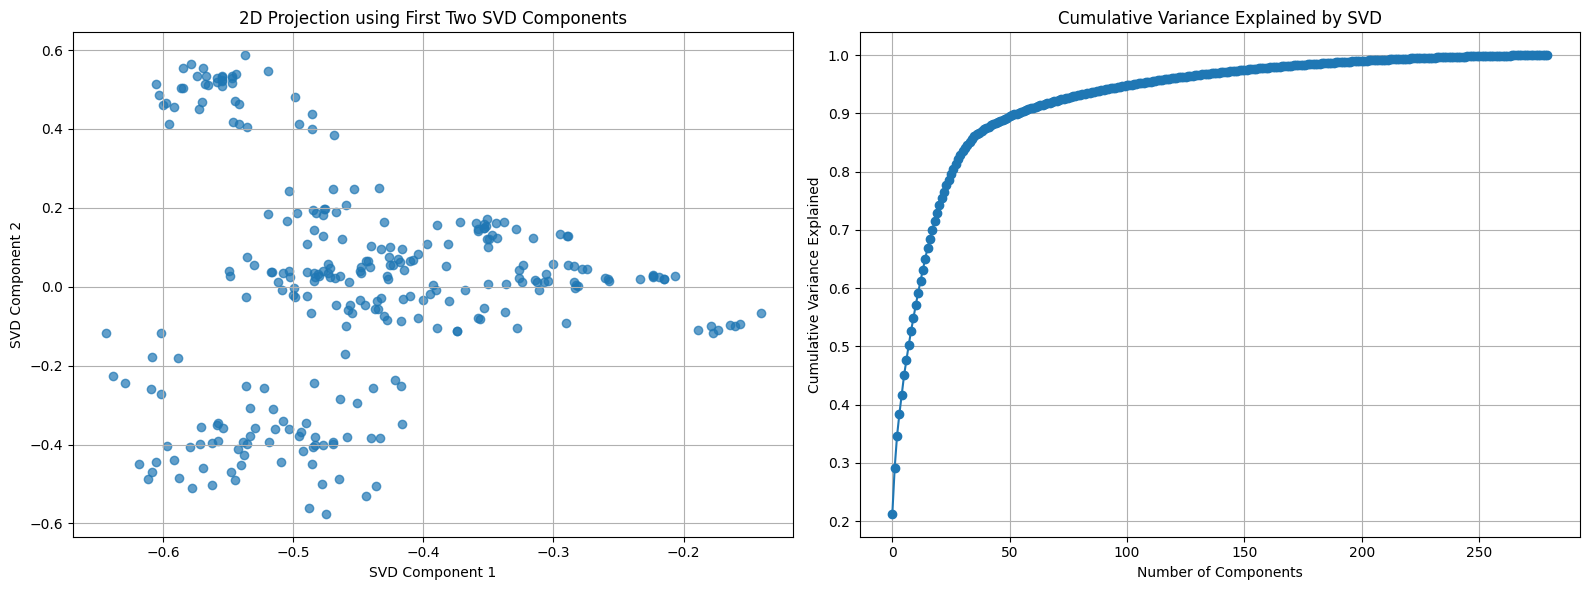

In [11]:
# Convert sparse matrix to dense
np.random.seed(42)
tfidf_dense = tfidf_dense_non_q1.copy()

# SVD
U, S, VT = np.linalg.svd(tfidf_dense, full_matrices=False)

explained_variance = (S ** 2) / np.sum(S ** 2) # Explained variance
svd_projection = U[:, :2] @ np.diag(S[:2]) # 2D SVD Projection

# Side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: 2D SVD Projection
axes[0].scatter(svd_projection[:, 0], svd_projection[:, 1], alpha=0.7)
axes[0].set_title('2D Projection using First Two SVD Components')
axes[0].set_xlabel('SVD Component 1')
axes[0].set_ylabel('SVD Component 2')
axes[0].grid(True)

# Plot 2: Cumulative Variance Explained
axes[1].plot(np.cumsum(explained_variance), marker='o')
axes[1].set_title('Cumulative Variance Explained by SVD')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].grid(True)

plt.tight_layout()
plt.show()


### We saved top 60 SVD components to do Clustering

In [12]:
svd = U[:, :NUMBER_OF_COMPONENTS] @ np.diag(S[:NUMBER_OF_COMPONENTS])
companies = non_q1_2025_df["company"].values
sectors = non_q1_2025_df["Sector"].values
quarters = non_q1_2025_df["quarter"].values

# Add metadata for our labeling purposes
svd_df = pd.DataFrame(svd, columns=[f"SVD_{i+1}" for i in range(NUMBER_OF_COMPONENTS)])
svd_df["Company"] = companies
svd_df["Sector"] = sectors
svd_df["Quarter"] = quarters

svd_df.to_csv(f"{data_save_file_path}/svd_{NUMBER_OF_COMPONENTS}_components.csv", index=False)

# 6. Truncated SVD
This section uses **Truncated Singular Value Decomposition (Truncated SVD)** to reduce the dimensionality of the sparse TF-IDF matrix. This approach is also known as Latent Semantic Analysis (LSA). It is ideal for handling large text corpora while preserving latent topic structures.

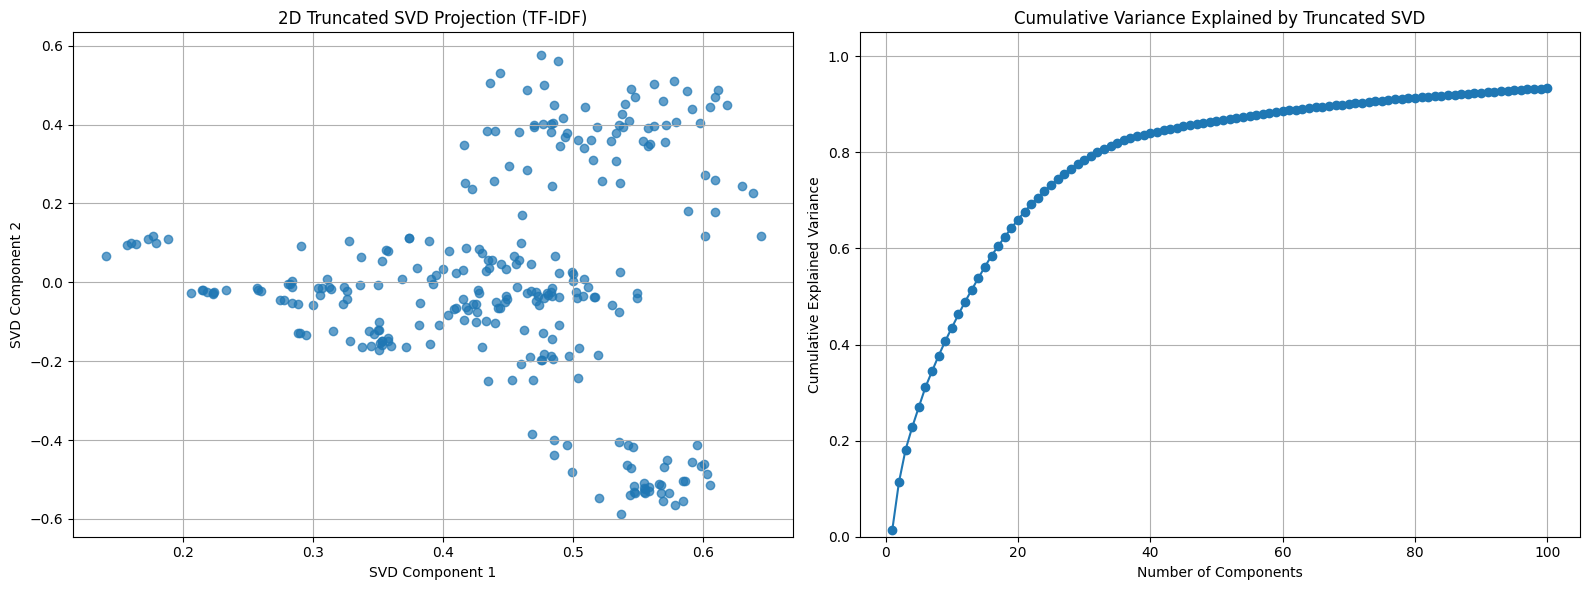

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Set random seed for reproducibility
np.random.seed(42)

# Determine number of features and safe number of SVD components
n_features = tfidf_dense.shape[1]
n_components = min(100, n_features - 1)  # cap to 100 or one less than feature count

# Apply Truncated SVD to the TF-IDF matrix
svd = TruncatedSVD(n_components=n_components, random_state=42)
reduced_matrix = svd.fit_transform(tfidf_dense)

# Calculate explained and cumulative variance
explained_variance = svd.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: 2D Projection using first 2 SVD components
axes[0].scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], alpha=0.7)
axes[0].set_title('2D Truncated SVD Projection (TF-IDF)')
axes[0].set_xlabel('SVD Component 1')
axes[0].set_ylabel('SVD Component 2')
axes[0].grid(True)

# Plot 2: Cumulative Explained Variance
axes[1].plot(range(1, n_components + 1), cumulative_variance, marker='o')
axes[1].set_title('Cumulative Variance Explained by Truncated SVD')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_ylim([0, 1.05])  # bound y-axis to [0, 1.05]
axes[1].grid(True)

plt.tight_layout()
plt.show()

### We saved top 60 Truncated SVD components to do Clustering

In [14]:

top_trunc_svd = reduced_matrix[:, :NUMBER_OF_COMPONENTS]
top_trunc_df = pd.DataFrame(top_trunc_svd, columns=[f"SVD_{i+1}" for i in range(NUMBER_OF_COMPONENTS)])

# Add metadata for our labeling purposes
top_trunc_df["Company"] = companies
top_trunc_df["Sector"] = sectors
top_trunc_df["Quarter"] = quarters

# Save to CSV
top_trunc_df.to_csv(f"{data_save_file_path}/truncated_svd_{NUMBER_OF_COMPONENTS}_components.csv", index=False)

# 7. PCA

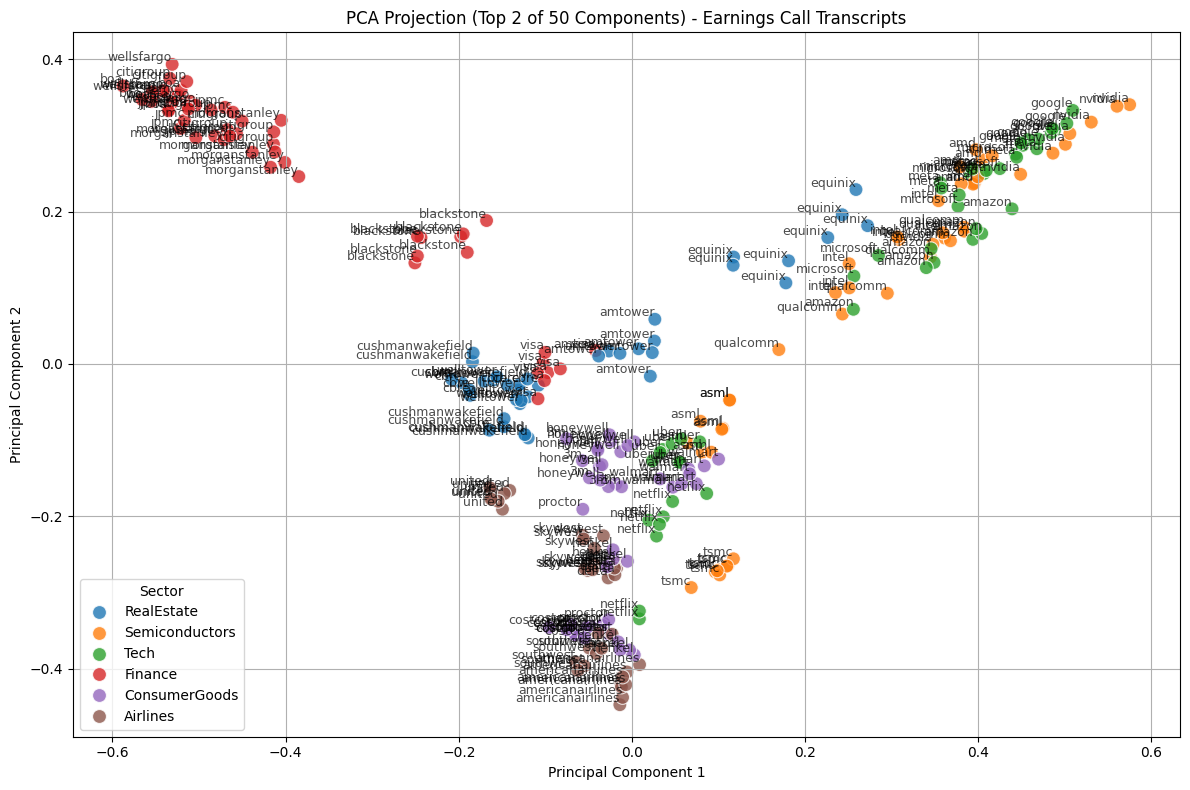

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Reduce to 2 principal components
np.random.seed(42)

# Perform PCA
pca = PCA(n_components=NUMBER_OF_COMPONENTS)
pca_result = pca.fit_transform(reduced_matrix)

# Create DataFrame for 2D visualization
df_vis = pd.DataFrame({
    "PC1": pca_result[:, 0],
    "PC2": pca_result[:, 1],
    "Company": [c.strip().lower() for c in companies],
    "Quarter": quarters
})
df_vis["Sector"] = df_vis["Company"].map(company_to_sector)

# Create and save full PCA results
df_full = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(NUMBER_OF_COMPONENTS)])
df_full["Company"] = df_vis["Company"]
df_full["Quarter"] = df_vis["Quarter"]
df_full["Sector"] = df_vis["Sector"]
df_full.to_csv(f"{data_save_file_path}/pca_{NUMBER_OF_COMPONENTS}_components.csv", index=False)

# Plot 2D projection
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_vis, x="PC1", y="PC2", hue="Sector", palette="tab10", s=100, alpha=0.8)

# Annotate each point with company name
for idx, row in df_vis.iterrows():
    plt.text(row["PC1"], row["PC2"], row["Company"], fontsize=9, ha='right', va='bottom', alpha=0.7)

plt.title(f"PCA Projection (Top 2 of {NUMBER_OF_COMPONENTS} Components) - Earnings Call Transcripts")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


# 8. Matrix Completion

Although our TF-IDF matrix does not contain traditional "missing values" as "zero" values meaningfully represent absent terms, we simulated missingness to evaluate the performance of matrix completion techniques. This allows us to test whether the underlying structure of the text data can be effectively recovered using low-rank approximation methods.

---

### We masked 35% of the data to do the simulation.

### Comments:

- The algorithm converged after 77 iterations with a regularization parameter 𝜆 ≈ 0.0957
- The effective rank stabilized at 145, indicating a relatively low-rank structure in the data.
- The mean squared error (MSE) on the masked values was 0.00038, demonstrating that SoftImpute was able to accurately recover the missing values.

In [17]:
np.random.seed(42)

# Step 1: Simulate missing values
tfidf_dense_completion = tfidf_dense.copy()
mask = tfidf_dense_completion != 0
missing_mask = (np.random.rand(*mask.shape) < 0.35) & mask
tfidf_missing = tfidf_dense_completion.copy()
tfidf_missing[missing_mask] = np.nan

# Step 2: Matrix completion with SoftImpute
completed_matrix = SoftImpute().fit_transform(tfidf_missing)

# Step 3: Evaluate only on masked values
true_values = tfidf_dense_completion[missing_mask]
predicted_values = completed_matrix[missing_mask]

mse = mean_squared_error(true_values, predicted_values)
print("MSE on masked values:", mse)

/home/exouser/EarningsTranscripts-NLP/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/exouser/EarningsTranscripts-NLP/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/exouser/EarningsTranscripts-NLP/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[SoftImpute] Max Singular Value of X_init = 5.066332
[SoftImpute] Iter 1: observed MAE=0.001678 rank=280
[SoftImpute] Iter 2: observed MAE=0.001728 rank=280
[SoftImpute] Iter 3: observed MAE=0.001774 rank=279
[SoftImpute] Iter 4: observed MAE=0.001813 rank=279
[SoftImpute] Iter 5: observed MAE=0.001847 rank=277
[SoftImpute] Iter 6: observed MAE=0.001875 rank=276
[SoftImpute] Iter 7: observed MAE=0.001898 rank=274
[SoftImpute] Iter 8: observed MAE=0.001916 rank=272
[SoftImpute] Iter 9: observed MAE=0.001932 rank=271
[SoftImpute] Iter 10: observed MAE=0.001945 rank=271
[SoftImpute] Iter 11: observed MAE=0.001956 rank=268
[SoftImpute] Iter 12: observed MAE=0.001965 rank=268
[SoftImpute] Iter 13: observed MAE=0.001973 rank=268
[SoftImpute] Iter 14: observed MAE=0.001980 rank=267
[SoftImpute] Iter 15: observed MAE=0.001985 rank=265
[SoftImpute] Iter 16: observed MAE=0.001990 rank=264
[SoftImpute] Iter 17: observed MAE=0.001994 rank=264
[SoftImpute] Iter 18: observed MAE=0.001998 rank=263
[S

# 8.1. SVD with Matrix Completion

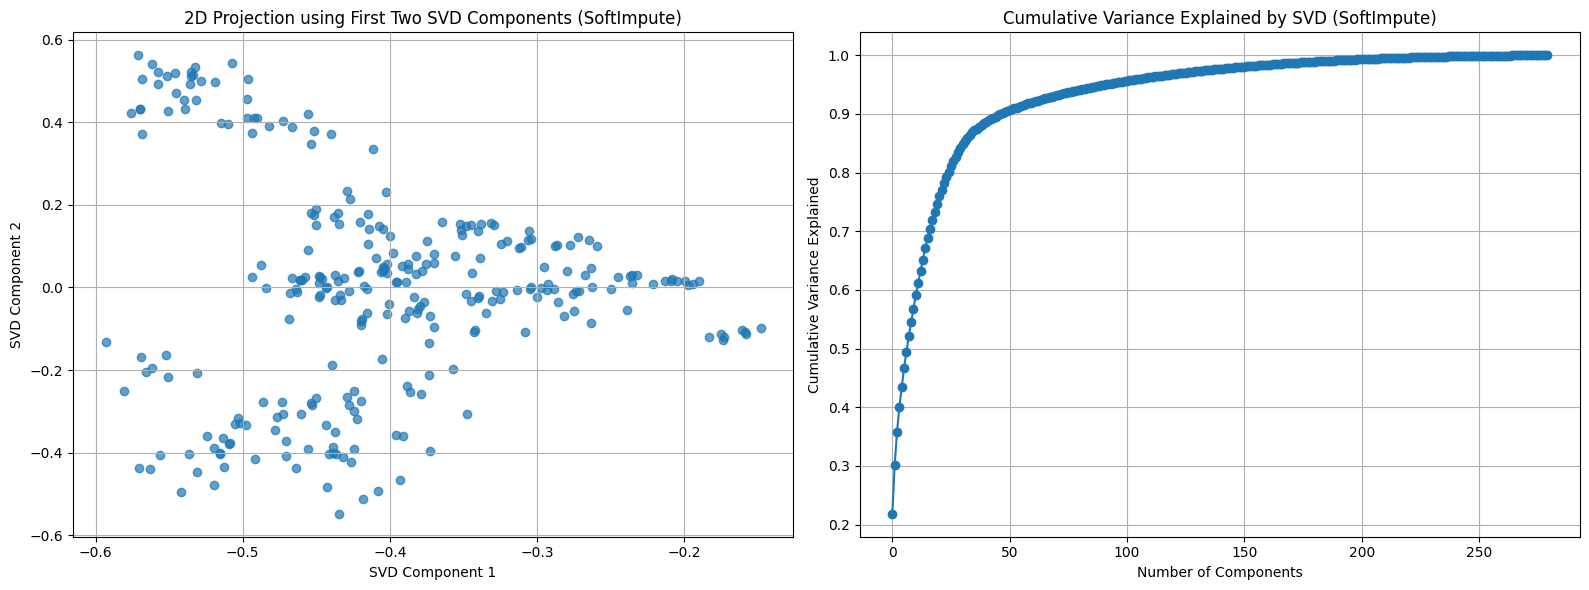

In [18]:
# 1. Set random seed for reproducibility
np.random.seed(42)

# 2. Perform SVD on the completed matrix
U, S, VT = np.linalg.svd(completed_matrix, full_matrices=False)

# 3. Compute explained variance
explained_variance = (S ** 2) / np.sum(S ** 2)  # Proportion of variance explained

# 4. Project onto first 2 components for visualization
svd_projection = U[:, :2] @ np.diag(S[:2])

# 5. Plot side-by-side: SVD projection + scree plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: 2D SVD Projection
axes[0].scatter(svd_projection[:, 0], svd_projection[:, 1], alpha=0.7)
axes[0].set_title('2D Projection using First Two SVD Components (SoftImpute)')
axes[0].set_xlabel('SVD Component 1')
axes[0].set_ylabel('SVD Component 2')
axes[0].grid(True)

# Plot 2: Cumulative Variance Explained
axes[1].plot(np.cumsum(explained_variance), marker='o')
axes[1].set_title('Cumulative Variance Explained by SVD (SoftImpute)')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### We saved top 60 Matrix Completion SVD components to do Clustering

In [19]:
matrix_completed_svd = U[:, :NUMBER_OF_COMPONENTS] @ np.diag(S[:NUMBER_OF_COMPONENTS])

# Add metadata for our labeling purposes
matrix_completed_svd_df = pd.DataFrame(matrix_completed_svd, columns=[f"SVD_{i+1}" for i in range(NUMBER_OF_COMPONENTS)])
matrix_completed_svd_df["Company"] = companies
matrix_completed_svd_df["Sector"] = sectors
matrix_completed_svd_df["Quarter"] = quarters
matrix_completed_svd_df.to_csv(f"{data_save_file_path}/matrix_completed_svd_{NUMBER_OF_COMPONENTS}_components.csv", index=False)

# 9. t-SNE Projection of TF-IDF Features

To visually explore the semantic relationships between earnings call transcripts, we applied t-SNE (t-distributed Stochastic Neighbor Embedding) on the TF-IDF representations.

- We first reduced the TF-IDF matrix using Truncated SVD to 100 components to preserve meaningful structure. (Like how we did above in the Truncated SVD)
- Then we applied PCA to reduce to 50 components, smoothing out noise and capturing the most amount of variance.
- Finally, we applied t-SNE to project the data into 2D for visualization.

---

### Comments:

**Sector clusters are clearly visible, particularly:**
- Tech companies (Google, Meta, Uber, etc.) group closely together.
- Semiconductors (e.g., AMD, Intel, NVIDIA, TSMC) show tight clustering, indicating similar language patterns.
- Airlines form a distinct cluster (Delta, United, American Airlines, Southwest).

Some companies, such as JPMC and CBRE, appear in slightly overlapping regions, suggesting shared terminology or themes across sectors like Finance and Real Estate.

Outliers, like 3M and a few earnings calls from Citigroup or American Airlines, suggest either unique language or contextual deviation during those quarters.

/home/exouser/EarningsTranscripts-NLP/venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


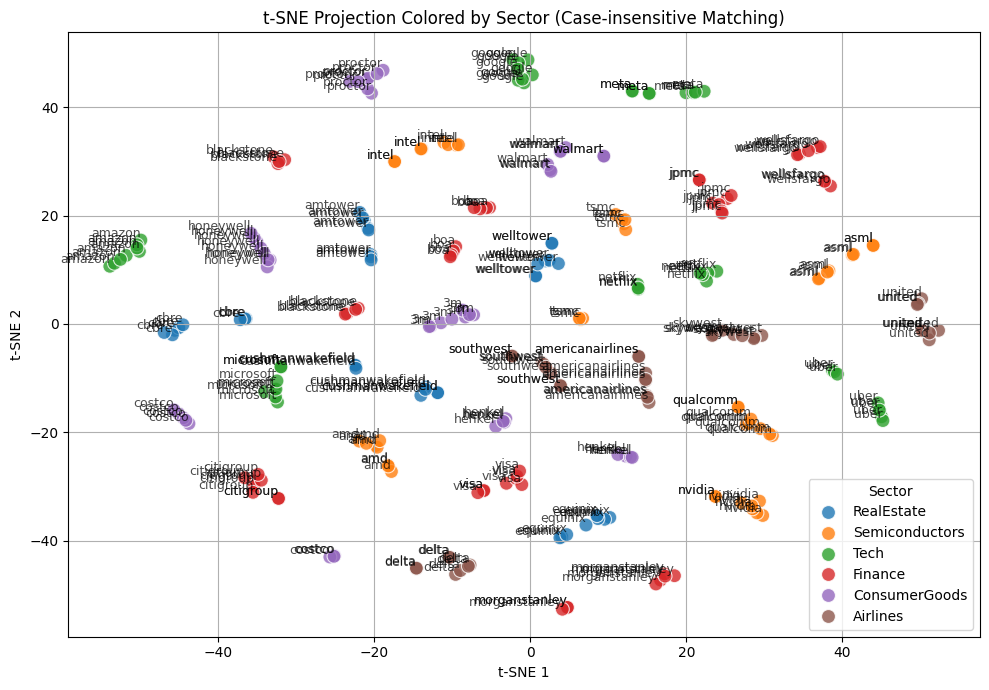

In [20]:
np.random.seed(42)

# Determine number of features and safe number of SVD components
n_features = tfidf_dense.shape[1]
n_components = min(100, n_features - 1)  # cap to 100 or one less than feature count

# Step 2: SVD (standard dimensionality reduction before t-SNE)
svd = TruncatedSVD(n_components=n_components, random_state=42)
reduced_matrix = svd.fit_transform(tfidf_dense)

# Step 3: PCA to 10 dimensions before t-SNE
n_pca_components = min(50, reduced_matrix.shape[1])
pca = PCA(n_components=n_pca_components, random_state=42)
pca_result = pca.fit_transform(reduced_matrix)

# t-SNE usually works better on already reduced data (e.g., via SVD)
tsne = TSNE(n_components=2, perplexity=2, random_state=42, n_iter=500)
tsne_result = tsne.fit_transform(pca_result)

# Prepare dataframe for plotting
df_plot = pd.DataFrame({
    "x": tsne_result[:, 0],
    "y": tsne_result[:, 1],
    "Company": companies,
    "Quarter": quarters
})

df_plot["Company"] = df_plot["Company"].str.strip().str.lower()
df_plot["Sector"] = df_plot["Company"].map(company_to_sector)

# Plot again using seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_plot, x="x", y="y", hue="Sector", palette="tab10", s=100, alpha=0.8)

for i in range(len(df_plot)):
    plt.text(
        df_plot["x"][i],
        df_plot["y"][i],
        df_plot["Company"][i],
        fontsize=9,
        ha='right',  # horizontal alignment
        va='bottom', # vertical alignment
        alpha=0.7
    )

plt.title("t-SNE Projection Colored by Sector (Case-insensitive Matching)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()